In [47]:
import os
import numpy as np
import pandas as pd
import sksurv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored
    
%matplotlib inline

In [2]:
os.chdir("/Users/helloniki77/Documents/ACCORD")

In [3]:
datapath='/Users/helloniki77/Documents/ACCORD'
datafiles=os.listdir(datapath)
print(datafiles)

['.DS_Store', 'final_sample.sas7bdat', 'sksurv']


In [4]:
finaldata=pd.read_sas(r"/Users/helloniki77/Documents/ACCORD/final_sample.sas7bdat")
finaldata.keys()

Index(['MaskID', 'female', 'baseline_age', 'white', 'chol', 'hdl', 'sbp',
       'htnmed', 'cigarett', 'event', 'fu'],
      dtype='object')

In [ ]:
print(finaldata)

In [ ]:
finaldata.describe()

In [ ]:
finaldata.describe()

In [ ]:
finaldata.sample(3)

In [5]:
finaldata['event'] = finaldata['event'].astype(int)

In [ ]:
finaldata['event'].value_counts() / finaldata.shape[0]

In [ ]:
finaldata['has_event']=finaldata['event']
a=finaldata['has_event']

finaldata['has_event'].head()


finaldata['has_event'] = finaldata['has_event'].astype(int).apply(lambda x: True if x==1 else False)
finaldata['has_event'] = finaldata['event'].astype(int).apply(lambda x: True if x==1 else False)


In [ ]:
finaldata['has_event'].unique()

In [ ]:
finaldata.loc[finaldata['fu']==10.0, 'has_event'] = False

In [ ]:
time, survival_prob = kaplan_meier_estimator(finaldata.has_event,finaldata.fu)
plt.step(time,survival_prob, where="post")

In [ ]:
finaldata[finaldata['fu']==10]['has_event'].value_counts()

In [ ]:
survival_prob

In [ ]:
_t = survival_prob
plt.plot(range(len(_t)), _t, 'bo-')

In [6]:


data_x=finaldata[["female","baseline_age",'white', 'chol', 'hdl', 'sbp',
       'htnmed', 'cigarett']]
data_y=finaldata[["event","fu"]]

#print(data_y.head())
#estimator = CoxPHSurvivalAnalysis()
#estimator.fit(data_x_numeric, data_y)

In [ ]:
#a, b 
data_y = []

for i in range(len(finaldata.fu)):
    #finaldata.has_event[i]
    #finaldata.fu[i]
    data_y.append((finaldata.event[i],finaldata.fu[i]))
    

In [ ]:
data_y = np.array(data_y)
int(data_y.event)
pd.concat([data_y,pd.get_dummies(data_y["Event"])],axis=1)

In [31]:
data_y.head()

,event,fu
0,0,10.000000
1,0,10.000000
2,0,2.004107
3,0,8.342231
4,0,9.776865


In [15]:
data_y_copy = data_y.copy()

data_y_copy['event'] = data_y_copy['event'].apply(lambda x: True if x==1 else False)

In [34]:
data_y_copy.head()

,event,fu
0,False,10.000000
1,False,10.000000
2,False,2.004107
3,False,8.342231
4,False,9.776865


In [40]:
_t = data_y_copy.values
print(_t.shape)

(6581, 2)


In [41]:
_t = np.array([tuple(ele) for ele in _t], dtype=[('Status', '?'), ('Survival_in_years', '<f8')])
_t

array([(False, 10.        ), (False, 10.        ), (False,  2.00410678),
       ..., (False, 10.        ), (False,  4.04106776),
       (False,  5.99315537)],
      dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

In [42]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, _t)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

In [45]:
pred_surv = estimator.predict_survival_function(data_x)

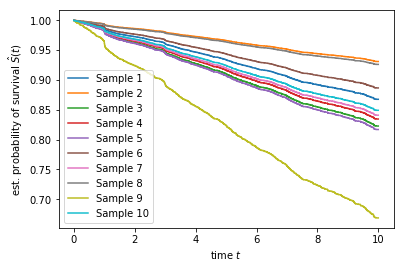

In [46]:
 for i, c in enumerate(pred_surv[:10]):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [49]:
prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y_copy["event"], data_y["fu"], prediction)
result[0]

0.6248248337670117

In [50]:
finaldata.head()

,MaskID,female,baseline_age,white,chol,hdl,sbp,htnmed,cigarett,event,fu
0,100001.0,0.0,60.8,1.0,189.0,51.0,127.0,1.0,0.0,0,10.000000
1,100002.0,1.0,55.0,1.0,188.0,47.0,109.0,1.0,0.0,0,10.000000
2,100003.0,1.0,57.3,0.0,270.0,41.0,143.0,1.0,1.0,0,2.004107
3,100004.0,1.0,72.5,1.0,205.0,38.0,114.0,1.0,0.0,0,8.342231
4,100006.0,1.0,56.7,1.0,317.0,41.0,133.0,1.0,0.0,0,9.776865


In [68]:
def cal_10yrs_risk_score(input_data):
    data = input_data.copy() # May cause trouble if the data size is too big...
    
    # Adjust bsurvrw:
    _col = 'bsurvrw'
    data[_col] = 0.0
    
    data.loc[(data['white']==1)&(data['female']==0), _col] = 0.9144
    data.loc[(data['white']==0)&(data['female']==0), _col] = 0.8954
    data.loc[(data['white']==1)&(data['female']==1), _col] = 0.9665
    data.loc[(data['white']==0)&(data['female']==1), _col] = 0.9533
    
    # Adjust bsurvrw:
    _col = 'bxave_rw'
    data[_col] = 0.0
    
    data.loc[(data['white']==1)&(data['female']==0), _col] = 61.18
    data.loc[(data['white']==0)&(data['female']==0), _col] = 19.54
    data.loc[(data['white']==1)&(data['female']==1), _col] = -29.18
    data.loc[(data['white']==0)&(data['female']==1), _col] = 86.61
    
    # Calculate bxrw:
    # meta feature:
    data['lsbp_trt'] = data.apply(lambda x: np.log(x['sbp']) if x['htnmed']==1 else 0.0, axis=1)
    data['lsbp_untrt'] = data.apply(lambda x: np.log(x['sbp']) if x['htnmed']==0 else 0.0, axis=1)
    
    _col = 'bxrw'
    data[_col] = 0.0
    
    _index = data[(data['white']==1)&(data['female']==0)].index
    _tmp_data = data.loc[_index]
    _res = 12.344*np.log(_tmp_data['baseline_age']) + \
           11.853*np.log(_tmp_data['chol']) - \
           2.664*np.log(_tmp_data['chol'])*np.log(_tmp_data['baseline_age']) - \
           7.990*np.log(_tmp_data['hdl']) + \
           1.769*np.log(_tmp_data['hdl']) * np.log(_tmp_data['baseline_age']) + \
           1.797*_tmp_data['lsbp_trt'] + \
           1.764*_tmp_data['lsbp_untrt'] + \
           7.837*_tmp_data['cigarett'] - \
           1.795*_tmp_data['cigarett']*np.log(_tmp_data['baseline_age']) + 0.658
    data.loc[_index, _col] = _res.squeeze()
                                                   
    _index = data[(data['white']==0)&(data['female']==0)].index
    _tmp_data = data.loc[_index]
    _res = 2.469*np.log(_tmp_data['baseline_age']) + \
           0.302*np.log(_tmp_data['chol']) - \
           0.307*np.log(_tmp_data['hdl']) + \
           1.916*_tmp_data['lsbp_trt'] + \
           1.809*_tmp_data['lsbp_untrt'] + \
           0.549*_tmp_data['cigarett'] + 0.645
    data.loc[_index, _col] = _res.squeeze()
                        
    index = data[(data['white']==1)&(data['female']==1)].index
    _tmp_data = data.loc[_index]
    _res = -29.799*np.log(_tmp_data['baseline_age']) + \
           4.884*np.log(_tmp_data['baseline_age']) ** 2 + \
           13.540*np.log(_tmp_data['chol']) - \
           3.114*np.log(_tmp_data['chol'])*np.log(_tmp_data['baseline_age']) - \
           13.578*np.log(_tmp_data['hdl']) + \
           3.149*np.log(_tmp_data['hdl']) * np.log(_tmp_data['baseline_age']) + \
           2.019*_tmp_data['lsbp_trt'] + \
           1.957*_tmp_data['lsbp_untrt'] + \
           7.574*_tmp_data['cigarett'] - \
           1.665*_tmp_data['cigarett']*np.log(_tmp_data['baseline_age']) + 0.661
    data.loc[_index, _col] = _res.squeeze()
                          
    index = data[(data['white']==0)&(data['female']==1)].index
    _tmp_data = data.loc[_index]
    _res = 17.114*np.log(_tmp_data['baseline_age']) + \
           0.940*np.log(_tmp_data['chol']) - \
           18.920*np.log(_tmp_data['hdl']) + \
           4.475*np.log(_tmp_data['hdl'])*np.log(_tmp_data['baseline_age']) + \
           29.291*_tmp_data['lsbp_trt'] - \
           6.432*_tmp_data['lsbp_trt']*np.log(_tmp_data['baseline_age']) + \
           27.820*_tmp_data['lsbp_untrt'] - \
           6.087*_tmp_data['lsbp_untrt']*np.log(_tmp_data['baseline_age']) + \
           0.691*_tmp_data['cigarett'] + 0.874
    data.loc[_index, _col] = _res.squeeze()
                         
    data['survrw'] = data['bsurvrw'] ** np.exp(data['bxrw']-data['bxave_rw'])
    data['probrw'] = 1.0 - data['survrw']
    data['ascvdrs'] = 100.0 * data['probrw']
                         
    return data

In [69]:
_t = cal_10yrs_risk_score(data_x)

In [70]:
_t.describe()

,female,baseline_age,white,chol,hdl,sbp,htnmed,cigarett,bsurvrw,bxave_rw,lsbp_trt,lsbp_untrt,bxrw,survrw,probrw,ascvdrs
count,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000,6581.000000
mean,0.441270,62.854931,0.607506,186.528035,43.008965,136.451299,0.800030,0.132047,0.931074,35.942238,3.929818,0.979061,39.952056,0.452282,0.547718,54.771778
std,0.496577,5.874120,0.488343,39.982933,11.528480,16.207562,0.400008,0.338567,0.027462,42.733972,1.967860,1.959086,36.686286,0.422469,0.422469,42.246866
min,0.000000,51.300000,0.000000,95.000000,19.000000,92.000000,0.000000,0.000000,0.895400,-29.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,58.000000,0.000000,158.000000,35.000000,125.000000,1.000000,0.000000,0.914400,19.540000,4.718499,0.000000,0.000000,0.000000,0.161157,16.115682
50%,0.000000,61.800000,1.000000,183.000000,41.000000,136.000000,1.000000,0.000000,0.914400,61.180000,4.875197,0.000000,61.885677,0.576880,0.423120,42.311964
75%,1.000000,66.500000,1.000000,211.000000,49.000000,147.000000,1.000000,0.000000,0.953300,61.180000,4.969813,0.000000,63.025671,0.838843,1.000000,100.000000
max,1.000000,79.300000,1.000000,317.000000,92.000000,179.000000,1.000000,1.000000,0.966500,86.610000,5.187386,5.187386,89.996601,1.000000,1.000000,100.000000


In [72]:
_t['ascvdrs'].value_counts()

100.000000    2897
0.000000      1295
24.385988        2
20.595750        1
48.048326        1
35.622436        1
58.772985        1
14.382461        1
44.597480        1
17.688504        1
25.713225        1
22.811197        1
24.024695        1
36.052529        1
19.647101        1
10.642455        1
62.368560        1
35.089957        1
49.570705        1
16.916366        1
14.390991        1
12.689712        1
37.312714        1
40.614524        1
31.171679        1
42.572136        1
43.828964        1
17.533872        1
27.837329        1
23.210005        1
              ... 
42.175355        1
28.753630        1
15.550625        1
56.723165        1
35.503105        1
58.278243        1
24.043885        1
17.302482        1
18.190866        1
29.564129        1
70.088107        1
50.080562        1
23.338442        1
13.673822        1
6.566328         1
18.135965        1
55.805375        1
29.392632        1
32.877614        1
15.767548        1
12.349953        1
41.713536   

In [73]:
!pwd

/Users/helloniki77/Documents/ACCORD
